In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import joblib
import warnings
warnings.filterwarnings('ignore')

In [99]:
df=pd.read_csv("weatherAUS.csv")
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [100]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

<AxesSubplot:>

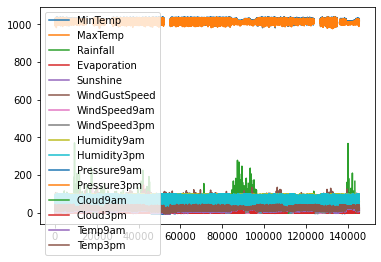

In [102]:
df.plot()

In [104]:
df.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation      62790
Sunshine         69835
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am         55888
Cloud3pm         59358
Temp9am           1767
Temp3pm           3609
RainToday         3261
RainTomorrow      3267
dtype: int64

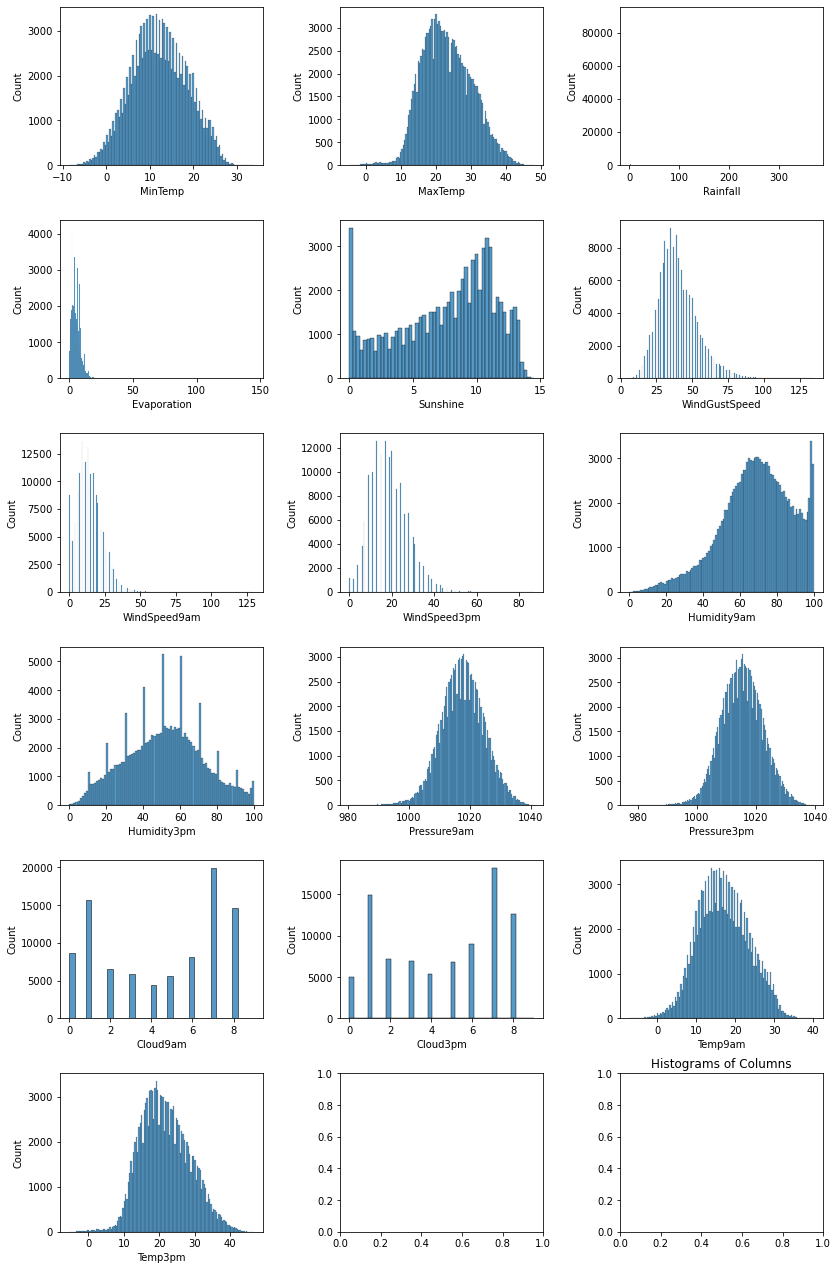

In [105]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12, 18))
axes = axes.reshape(-1)

continuous = [col for col in df.columns if df[col].dtype != object]
for i, col in enumerate(continuous):
    sns.histplot(df[col], ax=axes[i])

fig.tight_layout(pad=2.0)
plt.title('Histograms of Columns')
plt.savefig('histograms.png', facecolor='white', dpi=100);

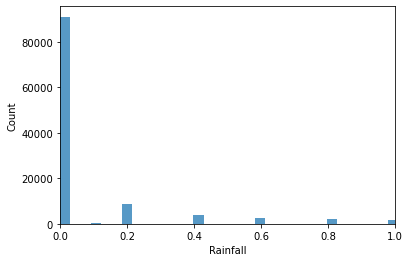

In [106]:
sns.histplot(df.Rainfall)
plt.xlim(0, 1);

In [107]:
df_seasonality = df.copy()
df_seasonality['month'] = df_seasonality.Date.apply(lambda x: int(str(x)[5:7]))
df_seasonality[['Date', 'month']].head()

,Date,month
0,2008-12-01,12
1,2008-12-02,12
2,2008-12-03,12
3,2008-12-04,12
4,2008-12-05,12


In [108]:
df.RainToday = df.RainToday.map({'No': 0, 'Yes': 1})
df.RainToday.value_counts(normalize=True)

0.0    0.775807
1.0    0.224193
Name: RainToday, dtype: float64

In [109]:
df.RainTomorrow = df.RainTomorrow.map({'No': 0, 'Yes': 1})
df.RainTomorrow.value_counts(normalize=True)

0.0    0.775819
1.0    0.224181
Name: RainTomorrow, dtype: float64

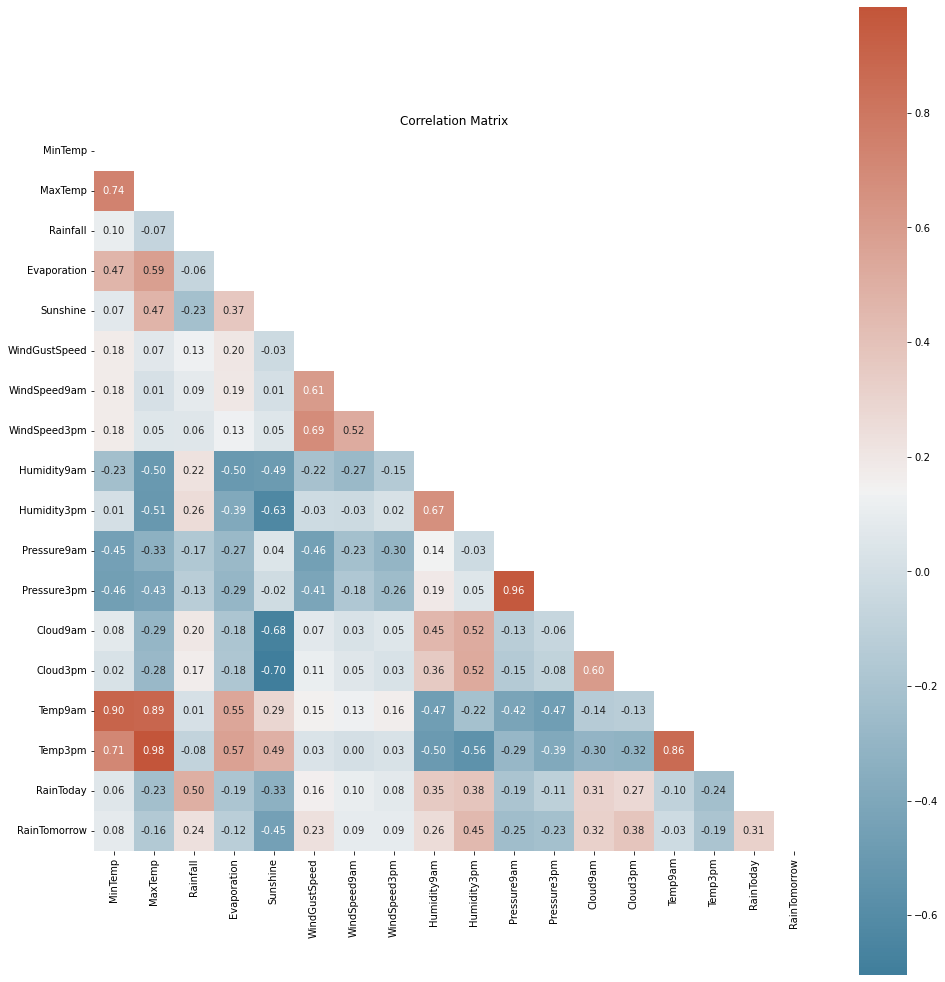

In [110]:
plt.figure(figsize=(14, 14))
plt.title('Correlation Matrix')

# Creating a mask to block the top right half of the heatmap (redundant information)
mask = np.triu(np.ones_like(df.corr()))

# Custom color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df.corr(), mask=mask, annot=True, fmt='.2f', square=True, cmap=cmap)
plt.tight_layout()



In [111]:
df_imputed = df.dropna(axis=0, subset=['RainTomorrow'])
df_imputed.isna().sum()

Date                 0
Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RainTomorrow         0
dtype: int64

In [152]:
cont_feats = [col for col in df_imputed.columns if df_imputed[col].dtype != object]
cont_feats.remove('RainToday')
cont_feats

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'Evaporation',
 'Sunshine',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Cloud9am',
 'Cloud3pm',
 'Temp9am',
 'Temp3pm',
 'RainTomorrow']

In [153]:
imputer = IterativeImputer(random_state=42)
df_imputed_cont = imputer.fit_transform(df_imputed[cont_feats])
df_imputed_cont = pd.DataFrame(df_imputed_cont, columns=cont_feats)
df_imputed_final=df_imputed_cont

In [154]:
df_imputed_cont.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainTomorrow     0
dtype: int64

In [147]:
df_imputed_final.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday
0,13.4,22.9,0.6,6.497888,7.048211,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,5.103048,16.9,21.8,0.0
1,7.4,25.1,0.0,6.270412,10.863393,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,1.912027,2.640581,17.2,24.3,0.0
2,12.9,25.7,0.0,8.659380,11.812408,46.0,19.0,26.0,38.0,30.0,1007.6,1008.7,2.014404,2.000000,21.0,23.2,0.0
3,9.2,28.0,0.0,6.764941,11.542532,24.0,11.0,9.0,45.0,16.0,1017.6,1012.8,1.201990,1.993914,18.1,26.5,0.0
4,17.5,32.3,1.0,7.455971,5.520080,41.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,0.0


In [148]:
df_imputed_final.isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
dtype: int64

In [157]:
df_final =df_imputed_final
X = df_final.drop(columns='RainTomorrow')
y = df_final.RainTomorrow

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print('Train size:', X_train.shape[0])
print('Test size: ', X_test.shape[0])
X_train


Train size: 106644
Test size:  35549


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
103079,14.9,30.3,0.0,7.400000,10.900000,33.000000,15.0,11.0,19.000000,12.000000,1021.100000,1017.800000,1.000000,1.000000,22.2,29.7
111021,14.6,21.5,0.2,6.359843,7.380439,46.000000,26.0,28.0,65.000000,57.000000,1012.600000,1013.500000,5.247184,5.142837,17.5,18.6
123110,9.0,23.7,0.0,4.970771,8.787805,28.000000,11.0,15.0,59.000000,45.000000,1020.623249,1016.768667,3.163683,3.336889,14.6,23.1
107740,15.3,24.0,0.0,8.200000,12.100000,26.640693,4.0,15.0,63.000000,82.000000,1018.100000,1016.700000,3.000000,3.000000,21.8,21.8
70263,17.3,37.5,0.0,8.600000,11.400000,39.000000,9.0,15.0,26.000000,12.000000,1009.600000,1006.200000,7.000000,4.000000,23.8,35.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,9.0,18.9,12.6,4.068264,5.185507,43.000000,20.0,15.0,67.825578,62.472646,1017.500000,1017.700000,4.809703,5.883400,15.8,17.6
119879,13.1,19.9,3.0,1.200000,2.300000,39.000000,2.0,13.0,90.000000,55.000000,1018.100000,1018.200000,7.000000,7.000000,15.4,19.1
103694,10.8,25.5,0.0,12.000000,13.000000,44.000000,26.0,15.0,41.000000,21.000000,1015.700000,1012.600000,0.000000,0.000000,15.3,23.1
131932,11.3,21.4,0.0,4.775816,5.254192,39.000000,19.0,22.0,75.000000,79.000000,1016.441568,1015.126198,8.000000,4.000000,15.8,15.7


In [162]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_pred

array([1, 0, 0, ..., 0, 1, 1])

In [165]:
def conf_matrix(model, X_test, y_test, cmap='Blues'):
    plot_confusion_matrix(model, X_test, y_test, cmap=cmap)
    plt.grid()
    plt.show()

def roc_curve_custom(model, X_test, y_test):
    plot_roc_curve(model, X_test, y_test)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.show()
    
def evaluate(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, y_pred=y_pred):
    # Confusion Matrix
    print('Confusion Matrix')
    print('-'*53)
    conf_matrix(model, X_test, y_test)
    print('\n') 
    
    # Classification Report
    print('Classification Report') 
    print('-'*53)
    print(classification_report(y_test, y_pred))
    print('\n')
    
    # ROC Curve
    print('ROC Curve')
    print('-'*53)
    roc_curve_custom(model, X_test, y_test)
    print('\n')
    
    # Checking model fitness
    print('Checking model fitness') 
    print('-'*53)
    print('Train score:', round(model.score(X_train, y_train), 4))
    print('Test score: ', round(model.score(X_test, y_test), 4))
    print('\n')
    



Confusion Matrix
-----------------------------------------------------


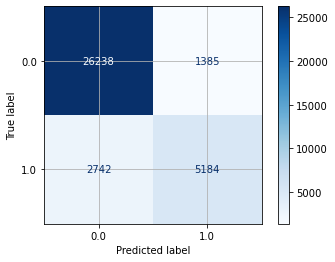



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93     27623
         1.0       0.79      0.65      0.72      7926

    accuracy                           0.88     35549
   macro avg       0.85      0.80      0.82     35549
weighted avg       0.88      0.88      0.88     35549



ROC Curve
-----------------------------------------------------


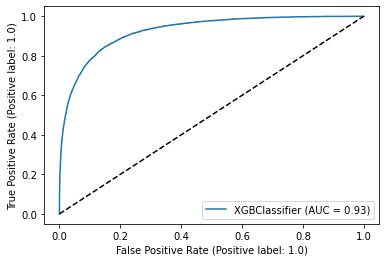



Checking model fitness
-----------------------------------------------------
Train score: 0.9136
Test score:  0.8839




In [164]:
evaluate(xgb, y_pred=y_pred_xgb)